In [ ]:
# 라이브러리 임포트
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm.notebook import tqdm
from google.colab import drive
import csv
import pandas as pd
import matplotlib.patches as patches
drive.mount('/content/drive')

# 파일 로드
basedir = os.getcwd() # set to '/HeartSignal/data'
projectdir = '/drive/MyDrive/HeartSignal/notebooks' # this can varies depending on your pwd
dataset = '/the-circor-digiscope-phonocardiogram-dataset-1.0.3'
datdir = basedir + projectdir + dataset + '/training_data'

# '.wav' 확장자를 가진 파일들만 한 번 검색하여 저장
wav_files = []
for file in tqdm(os.listdir(datdir), desc='Filtering .wav files'):
    if file.endswith('.wav'):
        wav_files.append(file)

Mounted at /content/drive


Filtering .wav files:   0%|          | 0/10431 [00:00<?, ?it/s]

In [ ]:
# Mel 범위로 변환
def get_mel_spectrogram(wave_form, sample_rate, n_mels, frame_length, frame_stride):
    """
    Convert an audio waveform to a Mel spectrogram.

    :param wave_form: NumPy array of audio waveform.
    :param sample_rate: Sampling rate of the audio.
    :param n_mels: Number of Mel bands to generate.
    :param frame_length: Length of each frame in seconds.
    :param frame_stride: Stride between successive frames in seconds.
    :return: Mel spectrogram (2D NumPy array).
    """
    # Calculate the number of samples per frame and stride
    win_length = int(round(sample_rate * frame_length))
    hop_length = int(round(sample_rate * frame_stride))

    # Calculate the number of FFT components (n_fft) as the next power of two from win_length
    n_fft = 2 ** int(np.ceil(np.log2(win_length)))

    # Compute the Mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=wave_form, sr=sample_rate, n_fft=n_fft,
                                                     hop_length=hop_length, win_length=win_length,
                                                     n_mels=n_mels)
    return mel_spectrogram

# 경계 시간 계산
def calculate_boundaries_time(file_path, sample_rate, frame_stride):
    """
    Calculate boundary times for audio events from a TSV file and convert them to sample indices.

    :param file_path: Path to the TSV file containing start and end times with labels.
    :param sample_rate: Sampling rate of the audio.
    :param frame_stride: Stride between successive frames in seconds.
    :return: A list of tuples with start and end indices and labels.
    """

    boundaries = []
    with open(file_path, 'r') as file:
        tsv_reader = csv.reader(file, delimiter='\t')

        # Read each line from the TSV file
        for row in tsv_reader:
            # Select rows where label is '1' or '3'
            if row[2] in ['1', '3']:
                start_time, end_time, label = float(row[0]), float(row[1]), int(row[2])

                # Append the start and end times with labels to the list
                boundaries.append((start_time, end_time, label))

    # Convert boundary times to sample indices
    hop_length = int(round(sample_rate * frame_stride))
    boundaries_in_samples = [
        (int(round(start * sample_rate / hop_length)),
         int(round(end * sample_rate / hop_length)), label)
        for start, end, label in boundaries
    ]

    return boundaries_in_samples

# 심음 경계 정보의 시작 및 종료 시점 추출
def calculate_cropped_indices(boundaries_time):
    """
    Calculate the average length of the heart sound events and use it to determine
    the start and end indices for cropping the Mel spectrogram.

    :param boundaries_time: List of tuples containing start and end indices with labels.
    :return: Tuple of integers representing the start and end indices for cropping.
    """

    # Calculate the average length of the heart sound events
    avg_length = np.mean([end - start for start, end, _ in boundaries_time]) / 2

    # Determine the start and end indices for cropping
    cropped_start = int(boundaries_time[0][0] - avg_length)
    cropped_end = int(boundaries_time[-1][1] + avg_length)

    # Ensure that the start and end indices are not negative
    cropped_start = max(0, cropped_start)
    cropped_end = max(0, cropped_end)

    return cropped_start, cropped_end

# 멜 스펙트로그램의 시작 및 종료 시점 기준 크롭
def get_cropped_mel(mel, cropped_start, cropped_end):
    """
    Crop the Mel spectrogram using the specified start and end indices.

    :param mel: 2D NumPy array of Mel spectrogram.
    :param cropped_start: Start index for cropping.
    :param cropped_end: End index for cropping.
    :return: Cropped Mel spectrogram.
    """

    # Ensure the cropping indices are within the bounds of the Mel spectrogram
    cropped_start = max(0, cropped_start)
    cropped_end = min(mel.shape[1], cropped_end)

    # Crop and return the Mel spectrogram
    return mel[:, cropped_start:cropped_end]

# Adjust the boundaries according to the cropping
def adjust_boundaries(boundaries_in_samples, cropped_start):
    """
    Adjust the start and end indices of each heart sound event based on the cropping start index.

    :param boundaries_in_samples: List of tuples with original start and end indices and labels.
    :param cropped_start: The start index used for cropping the Mel spectrogram.
    :return: List of tuples with adjusted start and end indices and labels.
    """

    adjusted_boundaries = []
    for start, end, label in boundaries_in_samples:
        # Adjust the start and end indices based on the cropped start index
        new_start = max(0, start - cropped_start)
        new_end = max(0, end - cropped_start)

        # Add the boundary to the list if it's valid (start index is before the end index)
        if new_start < new_end:
            adjusted_boundaries.append((new_start, new_end, label))

    return adjusted_boundaries

# 지정된 초(n_seconds) 이내로 범위 조정
def process_mel_and_boundaries(mel, boundaries, sample_rate, frame_stride, n_seconds):
    """
    Process Mel spectrogram and boundaries to fit a specified duration (n_seconds).

    This function adjusts the length of the Mel spectrogram and its associated boundaries.
    If the Mel spectrogram is shorter than the specified duration, it will be repeated
    until it fits. The boundaries will be recalculated to align with the modified Mel spectrogram.

    :param mel: 2D NumPy array representing the Mel spectrogram.
    :param boundaries: List of tuples representing start, end, and label of each boundary.
    :param sample_rate: Sampling rate of the audio.
    :param frame_stride: Stride between successive frames in seconds.
    :param n_seconds: Desired duration of the Mel spectrogram in seconds.
    :return: Tuple of adjusted Mel spectrogram and its boundaries.
    """

    # Calculate hop_length and target_length in samples
    hop_length = sample_rate * frame_stride
    target_length = int(n_seconds * sample_rate / hop_length)

    # Check if the original Mel spectrogram needs to be repeated
    original_length = mel.shape[1]
    if original_length >= target_length:
        # If the spectrogram is already long enough, crop it to the target length
        mel = mel[:, :target_length]
        repeat_times = 1
    else:
        # If the spectrogram is too short, repeat it until it reaches the target length
        repeat_times = int(np.ceil(target_length / original_length))
        mel = np.tile(mel, (1, repeat_times))[:, :target_length]

    # Process boundaries for the adjusted Mel spectrogram
    processed_boundaries = []
    for start, end, label in boundaries:
        # Iterate over the repeated segments
        for i in range(repeat_times):
            # Calculate new start and end points for the current segment
            new_start = start + i * original_length
            new_end = end + i * original_length

            # Check if the boundary is within the current segment
            segment_start = i * original_length
            segment_end = min((i + 1) * original_length, target_length)
            if new_start >= segment_start and new_end <= segment_end:
                # Add the adjusted boundary to the list
                processed_boundaries.append((new_start, new_end, label))

    # Return the adjusted Mel spectrogram and its boundaries
    return mel, processed_boundaries

# 특정 초 이내로 멜 크롭 (시작 시간(0)으로부터 seconds 까지)
def crop_mel_by_sec(mel, sample_rate, frame_stride, seconds):
    """
    Crop the Mel spectrogram to a specified length in seconds.

    :param mel: Mel spectrogram (2D NumPy array).
    :param sample_rate: Sampling rate of the original audio.
    :param frame_stride: Stride between successive frames in seconds.
    :param seconds: Desired length of the Mel spectrogram in seconds.
    :return: Cropped Mel spectrogram.
    """
    # Calculate hop length to align time axis
    hop_length = int(round(sample_rate * frame_stride))
    mel_duration = mel.shape[1] * hop_length / sample_rate

    # Return original Mel if specified seconds exceed its duration
    if seconds >= mel_duration:
        return mel

    # Calculate target length in samples and crop
    target_length = int(seconds * sample_rate / hop_length)
    return mel[:, :target_length]

# 정사각형 스펙트로그램 그리고 저장하기
def draw_mel_square_spec_and_save(mel, sample_rate, frame_stride, save_path, filename):
    """
    Draw a square Mel spectrogram and save it to a file.

    :param mel: Mel spectrogram (2D NumPy array).
    :param sample_rate: Sampling rate of the original audio.
    :param frame_stride: Stride between successive frames in seconds.
    :param save_path: Path to save the spectrogram image.
    :param filename: Filename for saving the image.
    """
    # Convert Mel spectrogram to Decibel scale
    S_dB = librosa.power_to_db(mel, ref=np.max)

    # Calculate hop length for time alignment
    hop_length = int(round(sample_rate * frame_stride))

    # Create a square figure
    fig, ax = plt.subplots(figsize=(3, 3), dpi=95)  # 256x256 pixels at 95 DPI

    # Display the Mel spectrogram
    librosa.display.specshow(S_dB, sr=sample_rate, hop_length=hop_length)
    ax.set_aspect('auto')

    # Save and display the spectrogram image
    print(f"{filename} spectrogram saved\n")
    plt.tight_layout()
    full_save_path = os.path.join(save_path, filename)
    plt.savefig(full_save_path, bbox_inches='tight', pad_inches=0)
    plt.show()

# 바운딩박스 레이블 그리고 저장하기
def draw_bbox_label_and_save(mel, sample_rate, frame_stride, boundaries_time, save_path, filename, label_1_height=1.0, label_3_height=1.0):
    """
    Draw bounding boxes on Mel spectrogram based on given boundaries and save it.

    :param mel: Mel spectrogram (2D NumPy array).
    :param sample_rate: Sampling rate of the original audio.
    :param frame_stride: Stride between successive frames in seconds.
    :param boundaries_time: List of tuples with start and end indices and label.
    :param save_path: Path to save the image.
    :param filename: Filename for saving the image.
    :param label_1_height: Height ratio of the bounding box for label 1.
    :param label_3_height: Height ratio of the bounding box for label 3.
    """
    # Set S_dB to a constant minimum value for a black background
    S_dB = np.full(mel.shape, -80)  # For example, -80 dB

    # Calculate hop length for time alignment
    hop_length = int(round(sample_rate * frame_stride))

    # Create a square figure
    fig, ax = plt.subplots(figsize=(3, 3), dpi=95)  # 256x256 pixels at 95 DPI

    # Display the Mel spectrogram with a gray color map
    librosa.display.specshow(S_dB, sr=sample_rate, hop_length=hop_length, cmap='gray')
    ax.set_aspect('auto')

    # Draw bounding boxes for each boundary
    for start_idx, end_idx, label in boundaries_time:
        color = 'blue' if label == 1 else 'red'
        height_ratio = label_1_height if label == 1 else label_3_height
        height = int(mel.shape[0] * height_ratio)
        rect = patches.Rectangle((start_idx, 0), end_idx - start_idx, height, linewidth=1, edgecolor=color, facecolor=color)
        ax.add_patch(rect)

    # Save and display the bounding box image
    print(f"{filename} bounding box segments label image saved\n")
    plt.tight_layout()
    full_save_path = os.path.join(save_path, filename + '_label')
    plt.savefig(full_save_path, bbox_inches='tight', pad_inches=0)
    plt.show()

# 실행

## [0]번 파일 테스트

85341_MV spectrogram saved



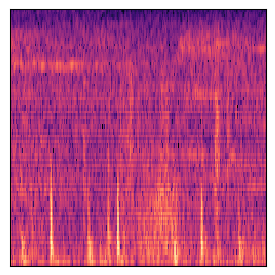

85341_MV bounding box segments label image saved



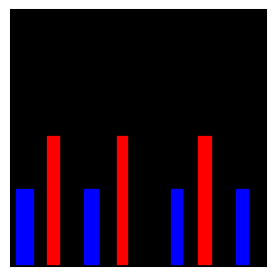

In [ ]:
# 변수 정의
# 각종 매개변수
sr = 4000
n_mels = 96
frame_length= 0.025
frame_stride=0.01

# 변수 정의
wav_name = wav_files[0]
file_name = wav_name[:-4]
wav_path = os.path.join(datdir, wav_name)

# 작업할 wav 파일 데이터 로드
y, sr = librosa.load(wav_path, sr=None)
mel = get_mel_spectrogram(y, sr, n_mels, frame_length, frame_stride)

# 원본 멜 스펙트로그램 위에 tsv 레이블 데이터 표시
boundaries_time = calculate_boundaries_time(wav_path[:-3] + 'tsv', sr, frame_stride)

# 레이블 있는 부분만 크롭
cropped_start, cropped_end = calculate_cropped_indices(boundaries_time)
c_mel = get_cropped_mel(mel, cropped_start, cropped_end)
adjusted_boundaries = adjust_boundaries(boundaries_time, cropped_start)

# 전체 길이 조정 (2.5초)
new_mel, new_b = process_mel_and_boundaries(c_mel, adjusted_boundaries, sr, frame_stride, 2.5)
seconds_cropped_mel = crop_mel_by_sec(c_mel, sr, frame_stride, 2.5)

# 경로 정의
img_save_path = './'
label_save_path = './'

# 필요한 디렉토리가 없으면 생성
os.makedirs(img_save_path, exist_ok=True)
os.makedirs(label_save_path, exist_ok=True)

# 실행 및 저장
draw_mel_square_spec_and_save(seconds_cropped_mel, sr, frame_stride, img_save_path, file_name)
draw_bbox_label_and_save(new_mel, sr, frame_stride, new_b, label_save_path, file_name, 0.3, 0.5)

## [0]번-[99]번까지 파일 저장

In [ ]:
# 변수 정의
# 각종 매개변수
sr = 4000
n_mels = 96
frame_length= 0.025
frame_stride=0.01

for wav_name in wav_files[:100]:
    # 변수 정의
    file_name = wav_name[:-4]
    wav_path = os.path.join(datdir, wav_name)

    # 작업할 wav 파일 데이터 로드
    y, sr = librosa.load(wav_path, sr=None)
    mel = get_mel_spectrogram(y, sr, n_mels, frame_length, frame_stride)

    # 원본 멜 스펙트로그램 위에 tsv 레이블 데이터 표시
    boundaries_time = calculate_boundaries_time(wav_path[:-3] + 'tsv', sr, frame_stride)

    # 레이블 있는 부분만 크롭
    cropped_start, cropped_end = calculate_cropped_indices(boundaries_time)
    c_mel = get_cropped_mel(mel, cropped_start, cropped_end)
    adjusted_boundaries = adjust_boundaries(boundaries_time, cropped_start)

    # 전체 길이 조정 (2.5초)
    new_mel, new_b = process_mel_and_boundaries(c_mel, adjusted_boundaries, sr, frame_stride, 2.5)
    seconds_cropped_mel = crop_mel_by_sec(c_mel, sr, frame_stride, 2.5)

    # 경로 정의
    img_save_path = basedir + projectdir + '/preprocessed_data/bbox_segment/256px_2halfsec_img/'
    label_save_path = basedir + projectdir + '/preprocessed_data/bbox_segment/256px_2halfsec_label/'

    # 필요한 디렉토리가 없으면 생성
    os.makedirs(img_save_path, exist_ok=True)
    os.makedirs(label_save_path, exist_ok=True)

    # 실행 및 저장
    draw_mel_square_spec_and_save(seconds_cropped_mel, sr, frame_stride, new_b, img_save_path, file_name, 0.3, 0.5)
    draw_bbox_label_and_save(new_mel, sr, frame_stride, new_b, label_save_path, file_name, 0.3, 0.5)

Output hidden; open in https://colab.research.google.com to view.